## **SARSA Agent**

In [1]:
!pip install box2d-py
!pip install gym[Box_2D]
import gym

     |████████████████████████████████| 450kB 8.6MB/s 


In [48]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

### **Declaración del agente**

In [56]:
class SARSAAgent:
    def __init__(self, environment, verbose=False):
        """ Inicializar el agente

        Args:
            environment (gym.wrappers.time_limit.TimeLimit): ambiente en el que se desenvuelve el agente
            verbose (bool, optional): habilitar los comentarios. Defaults to False.
        """
        # resguardamos el ambiente
        self._env = environment
        self._stateSize = self._env.observation_space.shape[0]
        self._actionSize = self._env.action_space.n

        # definimos tanto el número de buckets para cada valor de estado (x, y, Δx, Δy, θ, ω, cl, cr)
        # así como sus límites superior e inferior
        self._buckets = (5, 5, 5, 5, 5, 5, 2, 2)


        # creamos una lista con los límites superior e inferior de cada dimensión
        self._stateBounds = list(zip(self._env.observation_space.low, self._env.observation_space.high))
        # se fijan los valores para cada dimensión
        self._stateBounds[0] = [-1, 1] # x
        self._stateBounds[1] = [-1, 1] # y
        self._stateBounds[2] = [-1, 1] # Δx
        self._stateBounds[3] = [-1, 1] # Δy
        self._stateBounds[4] = [-1, 1] # θ
        self._stateBounds[5] = [-1, 1] # ω
        self._stateBounds[6] = [ 0, 1] # cl
        self._stateBounds[7] = [ 0, 1] # cr

        # reservamos memoria para almacenar los valores requeridos para
        # determinar la política
        self._QValues = np.zeros(self._buckets + (self._actionSize,))

        # parámetros que decaerán con el tiempo
        self._epsilon = 1.0
        self._gamma = 0.95
        self._lr = 1.0
        # constantes para decaer los parámetros
        self._minLr = 0.1
        self._minEpsilon = 0.1
        self._discount = 0.98
        self._decay = 25

        # otras cosas que requerimos
        self._verbose = verbose


    def _mapState(self, state):
        """ Transformar el estado continuo en un estado discreto mediante el empleo de buckets

        Args:
            state (tuple): el estado actual del ambiente

        Returns:
            list: el estado transformado
        """
        ratios = [ (state[i] + abs(self._stateBounds[i][0])) / (self._stateBounds[i][1] - self._stateBounds[i][0]) for i in range(len(state)) ]
        mState = [ int(round((self._buckets[i] - 1) * ratios[i])) for i in range(len(state)) ]
        mState = [ min(self._buckets[i] - 1, max(0, mState[i]))   for i in range(len(state)) ]
        return tuple(mState)


    def _decayEpsilon(self, t):
        """ calcular el decaimiento del exploration rate

        Args:
            t (int): instante de tiempo transcurrido durante el apisodio
        """
        self._epsilon = max(self._minEpsilon, min(1., 1. - math.log10((t + 1) / self._decay)))


    def _decayLearningRate(self, t):
        """ calcular el decaimiento del learning rate

        Args:
            t (int): instante de tiempo transcurrido durante el apisodio
        """
        self._lr = max(self._minLr, min(1., 1. - math.log10((t + 1) / self._decay)))


    def _chooseAction(self, state):
        """ Obtener la la mejor accion posible dado el estado del ambiente

        Args:
            state (list): el estado actual del ambiente

        Returns:
            int: la mejor accion posible
        """
        # aleatoriamente regresamos una acción aleatoria para ayudar al
        # agente a que no caiga en un minimo local
        if np.random.rand() <= self._epsilon:
            return random.randrange(self._actionSize)
        # retornamos la mejor accion posible
        return np.argmax(self._QValues[state])



    def _learn(self, state, newState, action, newAction, reward):
        """ Actualizar los Q-values con la ecuación de Bellman

        Args:
            state (tuple):  estado actual del ambiente
            newState ([type]): estado nuevo a partir de la acción generada
            action ([type]): acción realizada por el agente
            newAction ([type]): acción realizada por el agente a partir del nuevo estado
            reward (float): recompensa otorgada en base a la acción
        """
        # actualizar la matriz Q con la ecuación de Bellman
        self._QValues[state][action] += self._lr*(reward + self._gamma*(self._QValues[newState][newAction] - self._QValues[state][action])) # np.max

    def learn(self, episodes, timesteps):
        """ Someter al agente al proceso de aprendizaje

        Args:
            episodes (int): épocas de entrenamiento
            timesteps (int): instantes de tiempo en los que el ambiente se entrenará/evaluará
        """
        rewards = list()
        epsilon = list()

        # para cada epoca de entrenamiento
        for episode in range(episodes):
            tmp = 0
            # obtenemos el estado actual del ambiente y lo redimensionamos
            state = self._env.reset()
            state = self._mapState(state)

            # decaer el exploration rate por episodio
            self._decayEpsilon(episode)
            self._decayLearningRate(episode)

            # durante X pasos generaremos una acción sobre el ambiente
            # y obtendremos una recompensa.
            for t in range(timesteps):
                # AGENTE EJECUTA ACCIÓN DADO EL ESTADO ACTUAL
                action = self._chooseAction(state)
                # obtendremos el estado nuevo del ambiente ante el estimulo dado por el agente
                # y lo redimencionamos también
                newState, reward, done, _ = self._env.step(action)
                newState = self._mapState(newState)
                # AGENTE EJECUTA ACCIÓN DADO EL NUEVO ESTADO
                newAction = self._chooseAction(newState)

                self._learn(state, newState, action, newAction, reward)
                
                # actualizamos el estado actual con el nuevo
                state = newState
                tmp += reward
                # si terminó la época, salimos
                if done:
                    rewards.append(tmp)
                    epsilon.append(self._epsilon)
                    print("episode: {}/{}, steps: {}, R: {} ε: {}" .format(episode, episodes, t, tmp, self._epsilon))
                    break
            # cerramos el ambiente
            self._env.close()

        return rewards, epsilon

    def run(self, episodes):
        """ Hacer que el agente interactue con el ambiente

        Returns:
            int: intantes de tiempo que duró el agente interactuando con el ambiente
        """
        rewards = list()

        # para cada epoca de entrenamiento
        for episode in range(episodes):
          tmp, t = 0, 0
          done = False
          # obtenemos el estado actual del ambiente y lo redimensionamos
          state = self._env.reset()
          state = self._mapState(state)

          while not done:
            # self._env.render()
            t = t + 1
            # AGENTE EJECUTA ACCIÓN DADO EL ESTADO ACTUAL
            action = self._chooseAction(state)
            # obtendremos el estado nuevo del ambiente ante el estimulo dado por el agente
            # y lo redimencionamos también
            newState, reward, done, _ = self._env.step(action)
            newState = self._mapState(newState)
            # actualizamos el estado actual con el nuevo
            state = newState
            tmp += reward
          
          # cuando se termine la ejecucion del ambente...
          rewards.append(tmp)
          print("episode: {}/{}, steps: {}, R: {}" .format(episode, episodes, t, tmp))

        # cerramos el ambiente
        self._env.close()
        return rewards

### **Instanciar el agente y entrenarlo**

In [57]:
agent = SARSAAgent(environment=gym.make('LunarLander-v2'))

In [ ]:
rewards, epsilon = agent.learn(episodes=500, timesteps=1000)
print('training finished:')

### **Métricas de desempeño**

In [59]:
means = [0] + [sum(rewards[:num])/num for num in range(1, len(rewards))]
steps = [num for num, val in enumerate(rewards)]

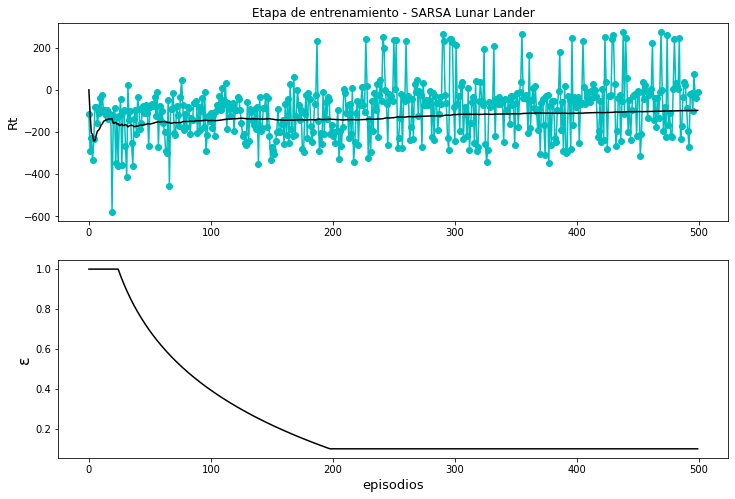

In [60]:
fig = plt.figure()
fig.set_size_inches(12, 8)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(steps, rewards, '-oc', steps, means, '-k')
ax2.plot(steps, epsilon, '-k')
ax1.set_title('Etapa de entrenamiento - SARSA Lunar Lander')
ax1.set_ylabel('Rt', fontsize=13)
ax2.set_ylabel('ε', fontsize=16)
ax2.set_xlabel('episodios', fontsize=13)

plt.show()

### **Observar al agente en acción**

In [ ]:
rewards = agent.run(episodes=200)

In [62]:
means = [0] + [sum(rewards[:num])/num for num in range(1, len(rewards))]
steps = [num for num, val in enumerate(rewards)]

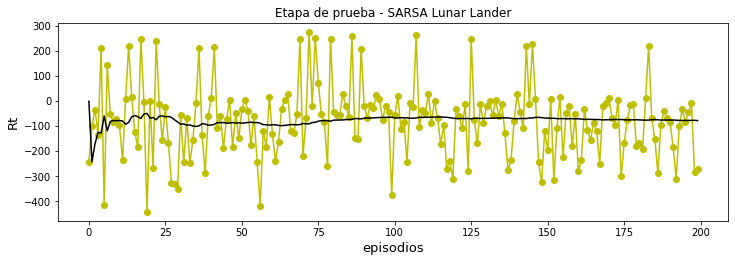

In [63]:
fig = plt.figure()
fig.set_size_inches(12, 8)
ax1 = fig.add_subplot(211)

ax1.plot(steps, rewards, '-oy', steps, means, '-k')
ax1.set_title('Etapa de prueba - SARSA Lunar Lander')
ax1.set_ylabel('Rt', fontsize=13)
ax1.set_xlabel('episodios', fontsize=13)

plt.show()